# Predict - Kaggle Climate Change Challenge

## This Predict focuses on Machine Learning: Classification methods
<img src= "https://www.blumeglobal.com/wp-content/uploads/2018/11/NLP-image.jpg">

Honour Code

I **Samantha, Reid,** confirm - by submitting this document - that the solutions in this notebook are a result of my own work and that I abide by the EDSA honour code 
https://drive.google.com/file/d/1QDCjGZJ8-FmJE3bZdIQNwnJyQKPhHZBn/view?usp=sharing).

Non-compliance with the honour code constitutes a material breach of contract.

## Problem statement:
## _Classify tweets on whether people in believe climate change or not_

## 1. Import the relevant packages

In [739]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pylab as pl
import seaborn as sns
import re

import nltk
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('stopwords')

from nltk import TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string
import urllib

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.utils import resample

from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, accuracy_score, log_loss

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\SREid\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SREid\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2. Import the data

In [740]:
test_df = pd.read_csv('https://raw.githubusercontent.com/st-reid/EDSA_Predict_Kaggle_Climate_Change/main/test.csv')

train_df = pd.read_csv('https://raw.githubusercontent.com/st-reid/EDSA_Predict_Kaggle_Climate_Change/main/train.csv')


In [741]:
train_df.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [742]:
test_df.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


#### the test data has no sentiment column so this must be the predicted column required

## 3. Exploratory data analysis

## 3.1 Check missing values

check if any sentiment has missing values

tokenize, remove web addresses, remove strange symbols

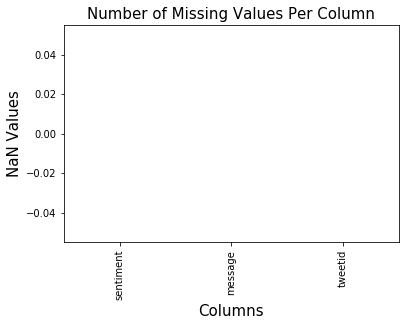

In [743]:
train_df.isnull().sum().plot(kind='bar', color='blue')
# Add a title and show the plot.
plt.title('Number of Missing Values Per Column', fontsize=15)
# Create tick mark labels on the Y axis and rotate them.
plt.xticks(rotation = 90)
# Create X axis label.
plt.xlabel("Columns", fontsize=15)
# Create Y axis label.
plt.ylabel("NaN Values",fontsize=15 );

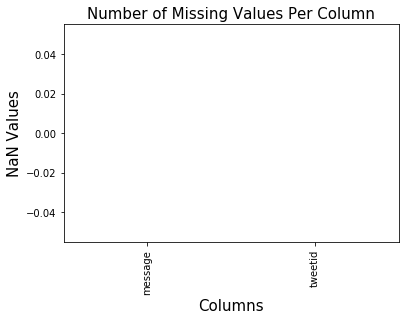

In [744]:
test_df.isnull().sum().plot(kind='bar', color='blue')
# Add a title and show the plot.
plt.title('Number of Missing Values Per Column', fontsize=15)
# Create tick mark labels on the Y axis and rotate them.
plt.xticks(rotation = 90)
# Create X axis label.
plt.xlabel("Columns", fontsize=15)
# Create Y axis label.
plt.ylabel("NaN Values",fontsize=15 );

### Seems like there are no missing values in the columns

## 3.2 Look at what categories are available for sentiments 

In [745]:
sentiment_labels = list(train_df.sentiment.unique())
print(sentiment_labels)

[1, 2, 0, -1]


- 2 = New links factual news about climate change
- 1 = Pro supports believe in man made climate change
- 0 = Neutral does not support or refute
- -0 = Anti does not believe in climate change

## 3.3  Exploratory data analysis 

### It is important to see what the distribution of the classes to determine the balance of the dataset

 1    53.922498
 2    23.010304
 0    14.874518
-1     8.192680
Name: sentiment, dtype: float64


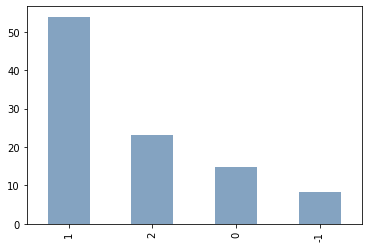

In [746]:
import plotly.graph_objects as go
import plotly.express as px

counts = train_df['sentiment'].value_counts()

total = len(train_df['sentiment'])

frequency = counts/total*100

frequency.plot(kind = 'bar',color=(0.2, 0.4, 0.6, 0.6))

print(frequency)

#plt.show()

### Majority of sentiment is in support of man made climate change which means the the other classes may not be as easy to train
### An imbalanced dataset means that predictions will be better for the sentiment with the most information and worse for sentiment with the least information

## 4.  Clean the train and test data

## The following were considered noise:
    
- @handles for tweets  
- hashtags
- Website addresses (URL)
- Unicode text
- Certain words at the beginning of sentences that had no meaning
- Numbers


## 4.1 Cleaning the train set of data first

### 4.1.1 Remove the noise

In [747]:
train_df1 = train_df.copy()

### convert data to lower case
print ('Convert data to lower case...')
train_df1['message'] = train_df1['message'].str.lower()

train_df1.head()

#remove URL's
print ('Remove urls...')
pattern_http = r'http[s]?://(?:[t.co/]|[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
subs_http = r""
train_df1['message'] = train_df1['message'].replace(to_replace = pattern_http, value = subs_http, regex = True)

pattern_http = r'http[s](?:[t.co/]|[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
subs_http = r""
train_df1['message'] = train_df1['message'].replace(to_replace = pattern_http, value = subs_http, regex = True)

pattern_http = r'http[s]+'
subs_http = r""
train_df1['message'] = train_df1['message'].replace(to_replace = pattern_http, value = subs_http, regex = True)

pattern_http = r'http+'
subs_http = r""
train_df1['message'] = train_df1['message'].replace(to_replace = pattern_http, value = subs_http, regex = True)


Convert data to lower case...
Remove urls...


In [748]:
train_df1.head()

,sentiment,message,tweetid
0,1,polyscimajor epa chief doesn't think carbon di...,625221
1,1,it's not like we lack evidence of anthropogeni...,126103
2,2,rt @rawstory: researchers say we have three ye...,698562
3,1,#todayinmaker# wired : 2016 was a pivotal year...,573736
4,1,"rt @soynoviodetodas: it's 2016, and a racist, ...",466954


### 4.1.2 Remove punctuation

In [749]:
### remove the punctuation
def remove_punctuation(message):      
    return ''.join([l for l in message if l not in string.punctuation])

In [750]:
train_df1['message'] = train_df1['message'].apply(remove_punctuation)
train_df1.head()

,sentiment,message,tweetid
0,1,polyscimajor epa chief doesnt think carbon dio...,625221
1,1,its not like we lack evidence of anthropogenic...,126103
2,2,rt rawstory researchers say we have three year...,698562
3,1,todayinmaker wired 2016 was a pivotal year in...,573736
4,1,rt soynoviodetodas its 2016 and a racist sexis...,466954


### 4.1.3 Tokenise the data

In [751]:
train_df2 = train_df1.copy()

#tokenize
tokeniser = TreebankWordTokenizer()
train_df2['tmessage'] = train_df2['message'].apply(tokeniser.tokenize)
train_df2.head()

,sentiment,message,tweetid,tmessage
0,1,polyscimajor epa chief doesnt think carbon dio...,625221,"[polyscimajor, epa, chief, doesnt, think, carb..."
1,1,its not like we lack evidence of anthropogenic...,126103,"[its, not, like, we, lack, evidence, of, anthr..."
2,2,rt rawstory researchers say we have three year...,698562,"[rt, rawstory, researchers, say, we, have, thr..."
3,1,todayinmaker wired 2016 was a pivotal year in...,573736,"[todayinmaker, wired, 2016, was, a, pivotal, y..."
4,1,rt soynoviodetodas its 2016 and a racist sexis...,466954,"[rt, soynoviodetodas, its, 2016, and, a, racis..."


### 4.1.4 Remove stop words

In [752]:
#def remove_stop_words(tokens):    
#    return [t for t in tokens if t not in stopwords.words('english')]

In [753]:
#train_df2['tmessage'] = train_df2['tmessage'].apply(remove_stop_words)
train_df2.head()

,sentiment,message,tweetid,tmessage
0,1,polyscimajor epa chief doesnt think carbon dio...,625221,"[polyscimajor, epa, chief, doesnt, think, carb..."
1,1,its not like we lack evidence of anthropogenic...,126103,"[its, not, like, we, lack, evidence, of, anthr..."
2,2,rt rawstory researchers say we have three year...,698562,"[rt, rawstory, researchers, say, we, have, thr..."
3,1,todayinmaker wired 2016 was a pivotal year in...,573736,"[todayinmaker, wired, 2016, was, a, pivotal, y..."
4,1,rt soynoviodetodas its 2016 and a racist sexis...,466954,"[rt, soynoviodetodas, its, 2016, and, a, racis..."


In [754]:
train_df2.to_csv('test_df2.csv')

### 4.1.5 Normalise the words
### Lemmatise to get rid of strange words

In [755]:
train_df3 = train_df2.copy()
lemmatizer = WordNetLemmatizer()

In [756]:
def climate_lemma(words, lemmatizer):
    return [lemmatizer.lemmatize(word) for word in words]    

In [757]:
train_df3['lemm'] = train_df3['tmessage'].apply(climate_lemma, args=(lemmatizer, ))

In [758]:
train_df3.head()

,sentiment,message,tweetid,tmessage,lemm
0,1,polyscimajor epa chief doesnt think carbon dio...,625221,"[polyscimajor, epa, chief, doesnt, think, carb...","[polyscimajor, epa, chief, doesnt, think, carb..."
1,1,its not like we lack evidence of anthropogenic...,126103,"[its, not, like, we, lack, evidence, of, anthr...","[it, not, like, we, lack, evidence, of, anthro..."
2,2,rt rawstory researchers say we have three year...,698562,"[rt, rawstory, researchers, say, we, have, thr...","[rt, rawstory, researcher, say, we, have, thre..."
3,1,todayinmaker wired 2016 was a pivotal year in...,573736,"[todayinmaker, wired, 2016, was, a, pivotal, y...","[todayinmaker, wired, 2016, wa, a, pivotal, ye..."
4,1,rt soynoviodetodas its 2016 and a racist sexis...,466954,"[rt, soynoviodetodas, its, 2016, and, a, racis...","[rt, soynoviodetodas, it, 2016, and, a, racist..."


### Tested stemming but added no value

### 4.1.6 Determining word density
### _see which words occur very little and perhaps consider removing them later in order to improve model_

In [759]:
def bag_of_words_count(words, word_dict={}):
    for word in words:
        if word in word_dict.keys():
            word_dict[word] += 1
        else:
            word_dict[word] = 1
    return word_dict

In [760]:
climate = {}
for pp in sentiment_labels:
    df = train_df3.groupby('sentiment')
    climate[pp] = {}
    for row in df.get_group(pp)['lemm']:
        climate[pp] = bag_of_words_count(row, climate[pp])  

In [761]:
all_words = set()
for pp in sentiment_labels:
    for word in climate[pp]:
        all_words.add(word)

In [762]:
climate['all'] = {}
for pp in sentiment_labels:    
    for word in all_words:
        if word in climate[pp].keys():
            if word in climate['all']:
                climate['all'][word] += climate[pp][word]
            else:
                climate['all'][word] = climate[pp][word]

In [763]:
total_words = sum([v for v in climate['all'].values()])
total_words

273117

Text(0.5, 0, 'word frequency')

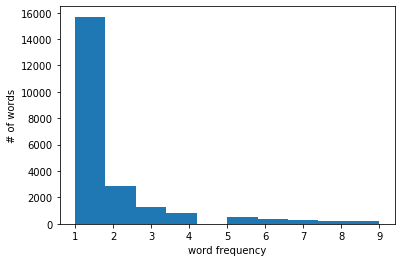

In [764]:
_ = plt.hist([v for v in climate['all'].values() if v < 10],bins=10)
plt.ylabel("# of words")
plt.xlabel("word frequency")

In [765]:
## copy out cleaned train set

train_clean = train_df3.copy()

train_clean.to_csv('train_clean.csv')

In [766]:
rare_words = [k for k, v in climate['all'].items() if v==1] 
print(rare_words[:100])

['hague', 'flipping', 'rein', 'iamjohnsparks', 'deteriorating', 'fbr', 'frightenin…', 'soilassociation', 'publicespecially', 'patrickesque', 'rosysaurusrex', 'muggy', 'childre…', 'bonkers', 'nvm', 'onecoschools', 'neoliberal', 'teamwildrose', 'worred', 'policy，im', 'focused…', 'balinteractive', 'guessing', 'paulrobbins15', 'carbon…', 'faoforestry', 'jenniferludden', 'circã¢â‚¬â¦', 'erupt', 'thiel', 'disbanding', 'jilã¢â‚¬â¦', 'democracyamp', 'rly', 'emerald', 'brilliantobiz', 'cancertrump', 'wrp', 'thomcincotta', 'mickfanning', 'royalfamily', 'kferris01', 'jusã¢â‚¬â¦', 'malcolmturnbull', 'whirlwind', 'incredulous', 'gautankwadis', 'niemanstory', 'rn��', 'perrymj', 'aspiring', 'worldbank', 'changefood', 'rate…', 'greenunl', 'cosmopolitan', 'lean', 'indignation', 'climatecrisis', 'janecaro', 'clp', 'yal', 'anthonyflint', '■womens', 'fam', 'california…', 'rainnwilson', '250m', 'harp', 'pharmasean', 'molonlabenews', 'ralphnader', 'baltimoresun', 'terminaiiychili', 'chuckgopal', 'sonjaswiss

In [767]:
#def remove_rare_words(tokens):    
#    return [t for t in tokens if t not in rare_words]

In [768]:
#remove rare words
train_df4=train_df3.copy()
#train_df4['lemm'] = train_df4['lemm'].apply(remove_rare_words)
#train_df4.head()

## 4.2 Prepare test set data

In [769]:
test_df1 = test_df.copy()
#convert lower case strings
print ('Convert data to lower case...')
test_df1['message'] = test_df1['message'].str.lower()

## URL removal
print ('Remove urls...')
pattern_http = r'http[s]?://(?:[t.co/]|[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
subs_http = r""
test_df1['message'] = test_df1['message'].replace(to_replace = pattern_http, value = subs_http, regex = True)

pattern_http = r'http[s](?:[t.co/]|[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
subs_http = r""
test_df1['message'] = test_df1['message'].replace(to_replace = pattern_http, value = subs_http, regex = True)

pattern_http = r'http[s]+'
subs_http = r""
test_df1['message'] = test_df1['message'].replace(to_replace = pattern_http, value = subs_http, regex = True)

pattern_http = r'http+'
subs_http = r""
test_df1['message'] = test_df1['message'].replace(to_replace = pattern_http, value = subs_http, regex = True)

Convert data to lower case...
Remove urls...


In [770]:
test_df1.head()

,message,tweetid
0,europe will now be looking to china to make su...,169760
1,combine this with the polling of staffers re c...,35326
2,"the scary, unimpeachable evidence that climate...",224985
3,@karoli @morgfair @osborneink @dailykos \nputi...,476263
4,rt @fakewillmoore: 'female orgasms cause globa...,872928


In [771]:
### remove the punctuation
def remove_punctuation(message):      
    return ''.join([l for l in message if l not in string.punctuation])

In [772]:
test_df1['message'] = test_df1['message'].apply(remove_punctuation)
test_df1.head()

,message,tweetid
0,europe will now be looking to china to make su...,169760
1,combine this with the polling of staffers re c...,35326
2,the scary unimpeachable evidence that climate ...,224985
3,karoli morgfair osborneink dailykos \nputin go...,476263
4,rt fakewillmoore female orgasms cause global w...,872928


In [773]:
## copy out cleaned test set
test_clean = test_df1.copy()
test_clean.to_csv('test_clean.csv')

In [774]:
test_df2 = test_df1.copy()
### tokenise
tokeniser = TreebankWordTokenizer()
test_df2['tmessage'] = test_df2['message'].apply(tokeniser.tokenize)
test_df2.head()

,message,tweetid,tmessage
0,europe will now be looking to china to make su...,169760,"[europe, will, now, be, looking, to, china, to..."
1,combine this with the polling of staffers re c...,35326,"[combine, this, with, the, polling, of, staffe..."
2,the scary unimpeachable evidence that climate ...,224985,"[the, scary, unimpeachable, evidence, that, cl..."
3,karoli morgfair osborneink dailykos \nputin go...,476263,"[karoli, morgfair, osborneink, dailykos, putin..."
4,rt fakewillmoore female orgasms cause global w...,872928,"[rt, fakewillmoore, female, orgasms, cause, gl..."


In [775]:
# remove stop words
#def remove_stop_words(tokens):    
#    return [t for t in tokens if t not in stopwords.words('english')]

In [776]:
#test_df2['tmessage'] = test_df2['tmessage'].apply(remove_stop_words)
test_df2.head()

,message,tweetid,tmessage
0,europe will now be looking to china to make su...,169760,"[europe, will, now, be, looking, to, china, to..."
1,combine this with the polling of staffers re c...,35326,"[combine, this, with, the, polling, of, staffe..."
2,the scary unimpeachable evidence that climate ...,224985,"[the, scary, unimpeachable, evidence, that, cl..."
3,karoli morgfair osborneink dailykos \nputin go...,476263,"[karoli, morgfair, osborneink, dailykos, putin..."
4,rt fakewillmoore female orgasms cause global w...,872928,"[rt, fakewillmoore, female, orgasms, cause, gl..."


In [777]:
def remove_rare_words(tokens):    
    return [t for t in tokens if t not in rare_words]

In [778]:
test_df3=test_df2.copy()
#remove rare words
#test_df3['tmessage'] = test_df3['tmessage'].apply(remove_rare_words)
#test_df3.head()

In [779]:
### lemmatize the words
lemmatizer = WordNetLemmatizer()

In [780]:
def climate_lemma(words, lemmatizer):
    return [lemmatizer.lemmatize(word) for word in words] 

In [781]:
test_df3['lemm'] = test_df3['tmessage'].apply(climate_lemma, args=(lemmatizer, ))

In [782]:
test_clean1 = test_df3.copy()
test_df3.head()

,message,tweetid,tmessage,lemm
0,europe will now be looking to china to make su...,169760,"[europe, will, now, be, looking, to, china, to...","[europe, will, now, be, looking, to, china, to..."
1,combine this with the polling of staffers re c...,35326,"[combine, this, with, the, polling, of, staffe...","[combine, this, with, the, polling, of, staffe..."
2,the scary unimpeachable evidence that climate ...,224985,"[the, scary, unimpeachable, evidence, that, cl...","[the, scary, unimpeachable, evidence, that, cl..."
3,karoli morgfair osborneink dailykos \nputin go...,476263,"[karoli, morgfair, osborneink, dailykos, putin...","[karoli, morgfair, osborneink, dailykos, putin..."
4,rt fakewillmoore female orgasms cause global w...,872928,"[rt, fakewillmoore, female, orgasms, cause, gl...","[rt, fakewillmoore, female, orgasm, cause, glo..."


## 5. Prepare data for modelling  into labels and features

In [783]:
train_df4 = train_df3.copy()
y = train_df3['sentiment']

In [784]:
train_df4['lemm']=[" ".join(lemm) for lemm in train_df4['lemm'].values]

In [785]:
train_df4.head()

,sentiment,message,tweetid,tmessage,lemm
0,1,polyscimajor epa chief doesnt think carbon dio...,625221,"[polyscimajor, epa, chief, doesnt, think, carb...",polyscimajor epa chief doesnt think carbon dio...
1,1,its not like we lack evidence of anthropogenic...,126103,"[its, not, like, we, lack, evidence, of, anthr...",it not like we lack evidence of anthropogenic ...
2,2,rt rawstory researchers say we have three year...,698562,"[rt, rawstory, researchers, say, we, have, thr...",rt rawstory researcher say we have three year ...
3,1,todayinmaker wired 2016 was a pivotal year in...,573736,"[todayinmaker, wired, 2016, was, a, pivotal, y...",todayinmaker wired 2016 wa a pivotal year in t...
4,1,rt soynoviodetodas its 2016 and a racist sexis...,466954,"[rt, soynoviodetodas, its, 2016, and, a, racis...",rt soynoviodetodas it 2016 and a racist sexist...


In [786]:
### initialise the vectorizer
vectorizer = TfidfVectorizer()
X_vectorized = vectorizer.fit_transform(train_df4['lemm'])

In [787]:
#train test split
X_train,X_test,y_train,y_test = train_test_split(X_vectorized.toarray(), y,test_size=.2, shuffle=True, random_state=42)


In [788]:
### Check the Array
print(X_train)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## 6. Train the model

##### I use SGD as a quick test on performance as it runs quickly

In [789]:
sgd = SGDClassifier(random_state=42)
sgd_fitted = sgd.fit(X_train, y_train)
y_pred_train_sgd = sgd_fitted.predict(X_test)

In [790]:
f1_score(y_test, y_pred_train_sgd, average="macro")

0.6511013674643461

#### Now I run SVM as my main model as it gives better results but takes a long time to run

In [791]:
SVM = SVC(C=1.0, kernel='linear', gamma=0.5)
svm_fitted = SVM.fit(X_train, y_train)
y_pred_train_svm = svm_fitted.predict(X_test)

In [792]:
f1_score(y_test, y_pred_train_svm, average="macro")

0.6538374002765923

## 7. Prepare test data and export to prepare for Kaggle submission

In [793]:
test_df4= test_df3.copy()

test_df4['lemm']=[" ".join(lemm) for lemm in test_df4['lemm'].values]

X_test_vect = vectorizer.transform(test_df4['lemm']).toarray()

print(X_test_vect)


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [794]:
##prep and pray

y_pred_train_svm = svm_fitted.predict(X_test_vect)

In [795]:
test_df3['sentiment'] = y_pred_train_svm

## export predictions and start praying for mercy

test_df3[['tweetid','sentiment']].to_csv('svm_submit_final.csv', index=False)

## 8. Conclusions 

- NLP is quite difficult and requires much time cleaning the data and understanding what should be added and removed
- Using the correct model is crucial - I chose SVM as it yielded the best score. It took a really long time to run though. I tried to run a grid search to optimise SVM - it ran overnight and never stopped running! As a quick check I used SGDClassifier - it was just as good and took significantly shorter time to run.
- NLP with machine learning does not always perform as you would expect - in my case I had cleaned the data quite a bit but gotten not so good results. In the end I left the dataset fairly 'dirty' and got better results


<img src= "https://www.asylas.com/wp-content/uploads/2019/12/close-up-of-scrabble-tiles-forming-the-words-the-end-2889685-1024x683.jpg">